# **0. GPU 사용하도록 설정**

* 런타임유형변경 -> T4 GPU

In [211]:
!pip install pytorch_accelerated torchmetrics scikit-learn

**필요 데이터셋 및 라이브러리 다운로드**

In [212]:
!gdown --folder https://drive.google.com/drive/folders/1avlObuABB41jNnr3YTpx-3XSdg4vhvxl?usp=sharing.. -O ./lib

Retrieving folder contents
Retrieving folder 1w9pv6f1PyLa_bqAwKfygHjODxdNNC_Ry __pycache__
Processing file 1vahGpIWNNjw9UOM1v-59tYOYdHolKepX engines.cpython-310.pyc
Processing file 1o-Ox1MQRgPzdw--7BvVVFpQyq1pchkl7 models.cpython-310.pyc
Processing file 1FsQii0ZOKhLdJtclUuCSeg7H9aGNwEpH utils.cpython-310.pyc
Processing file 1QvlHaqvmwOMUabNoUXixKP-9Ru8My-nf datasets.py
Processing file 1dgmftc4Bv_AlAYPY3g1FN95cW2c2Gc41 engines.py
Processing file 1dbrGCShn-OEyy1LayzRkN1lBMdvKhVDJ utils.py
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1vahGpIWNNjw9UOM1v-59tYOYdHolKepX
From (redirected): https://drive.google.com/uc?id=1vahGpIWNNjw9UOM1v-59tYOYdHolKepX&confirm=t&uuid=f4e058d1-7387-4142-a7c7-f3e60b6fc6d1
To: /content/lib/__pycache__/engines.cpython-310.pyc
100% 1.24k/1.24k [00:00<00:00, 6.81MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1o-Ox1MQRgPzd

In [213]:
# !gdown 1jyM2RPdmqZTe--WTw7t9qzxC0co8w61T
# !unzip -qq './dataset.zip'

Downloading...
From (original): https://drive.google.com/uc?id=1jyM2RPdmqZTe--WTw7t9qzxC0co8w61T
From (redirected): https://drive.google.com/uc?id=1jyM2RPdmqZTe--WTw7t9qzxC0co8w61T&confirm=t&uuid=2f6aa506-ab0f-42b9-94b8-c2e90ae2915f
To: /content/dataset.zip
100% 441M/441M [00:01<00:00, 242MB/s]
replace dataset/이물질/frame738.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [214]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
import numpy as np
import time
import torchvision
import random
import logging
import argparse
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import easydict
import torchsummary
import matplotlib.pyplot as plt
import pandas as pd

#data
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics import Accuracy

#data transforms
from torch.autograd import Variable
from torchvision import datasets, transforms

# #lib
# #from lib.datasets import CIFAR10_MEAN, CIFAR10_STD
# from lib.models import ResNet
from lib.engines import train_one_epoch, eval_one_epoch
from lib.utils import save_model

# **1. 데이터 라벨링**

### 이미지 수 지정

In [217]:
# 랜덤하게 뽑아 낼 이미지 수

num_copies = 300

### 이미지에 라벨 할당(정상, 하자)

In [218]:
import os
import random

path = os.getcwd()

nomal_list = os.listdir(path+'/dataset/정상')
bending_list = os.listdir(path + '/dataset/구부러짐')
dust_list = os.listdir(path + '/dataset/이물질')
punching_list = os.listdir(path + '/dataset/펀칭')

print('정상 이미지 수: ',len(nomal_list) )
print('구부러짐 이미지 수: ',len(bending_list) )
print('이물질 이미지 수: ',len(dust_list) )
print('펀칭 이미지 수: ',len(punching_list) )

정상 이미지 수:  1505
구부러짐 이미지 수:  145
이물질 이미지 수:  35
펀칭 이미지 수:  188


In [219]:
# 비율 동일

# 정상 배관 이미지
nomal_path = []
nomal_label = []
random.shuffle(nomal_list)
selected_paths = random.choices(nomal_list, k = num_copies)
nomal_path = [f"/dataset/정상/{image}" for image in selected_paths]
nomal_label = ["정상"] * len(selected_paths)
print(len(nomal_path))

# 구부러짐 배관 이미지
bending_path = []
bending_label = []
random.shuffle(bending_list)
selected_paths = random.choices(bending_list, k = num_copies)
bending_path = [f"/dataset/구부러짐/{image}" for image in selected_paths]
bending_label = ["구부러짐"] * len(selected_paths)
print(len(bending_path))

# 이물질 배관 이미지
dust_path = []
dust_label = []
random.shuffle(dust_list)
selected_paths = random.choices(dust_list, k = num_copies)
dust_path = [f"/dataset/이물질/{image}" for image in selected_paths]
dust_label = ["이물질"] * len(selected_paths)
print(len(dust_path))

# 펀칭 배관 이미지
punching_path = []
punching_label = []
random.shuffle(punching_list)
selected_paths = random.choices(punching_list, k = num_copies)
punching_path = [f"/dataset/펀칭/{image}" for image in selected_paths]
punching_label = ["펀칭"] * len(selected_paths)
print(len(punching_path))

# 이미지의 경로와 라벨을 리스트로
file_path_list = nomal_path + bending_path + dust_path + punching_path
file_label_list = nomal_label + bending_label + dust_label + punching_label

print(file_path_list)
print(file_label_list)
print('총 데이터 수: ',len(file_path_list))

300
300
300
300
['/dataset/정상/frame1071.png', '/dataset/정상/frame529.png', '/dataset/정상/frame36.png', '/dataset/정상/frame1240.png', '/dataset/정상/frame884.png', '/dataset/정상/frame517.png', '/dataset/정상/frame948.png', '/dataset/정상/frame49.png', '/dataset/정상/frame1060.png', '/dataset/정상/frame683.png', '/dataset/정상/frame327.png', '/dataset/정상/frame18.png', '/dataset/정상/frame362.png', '/dataset/정상/frame367.png', '/dataset/정상/frame383 (2).png', '/dataset/정상/frame936.png', '/dataset/정상/frame653.png', '/dataset/정상/frame1281.png', '/dataset/정상/frame939.png', '/dataset/정상/frame54.png', '/dataset/정상/frame332.png', '/dataset/정상/frame810.png', '/dataset/정상/frame538.png', '/dataset/정상/frame394 (2).png', '/dataset/정상/frame1311.png', '/dataset/정상/frame609.png', '/dataset/정상/frame319 (2).png', '/dataset/정상/frame940.png', '/dataset/정상/frame8.png', '/dataset/정상/frame386 (2).png', '/dataset/정상/frame241.png', '/dataset/정상/frame1162.png', '/dataset/정상/frame317 (2).png', '/dataset/정상/frame109.png', '/dataset/정

### csv 파일로 이미지 경로와 라벨을 저장

In [220]:
df = pd.DataFrame(file_path_list, columns=['Path'])
df['Label'] = file_label_list

df.to_csv("pipe_multi.csv", index=False)
pipe = pd.read_csv(path  +'/pipe_multi.csv')
print(pipe.head())
print(pipe.tail())

                        Path Label
0  /dataset/정상/frame1071.png    정상
1   /dataset/정상/frame529.png    정상
2    /dataset/정상/frame36.png    정상
3  /dataset/정상/frame1240.png    정상
4   /dataset/정상/frame884.png    정상
                          Path Label
1195  /dataset/펀칭/frame450.png    펀칭
1196  /dataset/펀칭/frame571.png    펀칭
1197  /dataset/펀칭/frame578.png    펀칭
1198  /dataset/펀칭/frame562.png    펀칭
1199  /dataset/펀칭/frame476.png    펀칭


# **2. 데이터 분리**

### 데이터 섞기

In [221]:
# 학습을 위해 라벨을 재할당
mapping = {'정상': 0,
           '구부러짐': 1,
           '이물질': 2,
           '펀칭': 3}
pipe.Label = pipe.Label.map(mapping)

np.random.seed(21)
random_index = np.random.permutation(pipe.index) # 랜덤하게 인덱스 생성
pipe = pipe.iloc[random_index] # 랜덤하게 생성한 인덱스 순서로 재배열
pipe = pipe.reset_index(drop=True) # 다시 순서대로 인덱스 부여

print(pipe.head(100))

                              Path  Label
0         /dataset/정상/frame418.png      0
1   /dataset/구부러짐/frame168 (2).png      1
2         /dataset/펀칭/frame554.png      3
3   /dataset/구부러짐/frame149 (2).png      1
4       /dataset/정상/frame7 (2).png      0
..                             ...    ...
95    /dataset/정상/frame390 (2).png      0
96       /dataset/이물질/frame997.png      2
97        /dataset/펀칭/frame447.png      3
98        /dataset/정상/frame368.png      0
99        /dataset/정상/frame836.png      0

[100 rows x 2 columns]


### train, val, test 분리

In [222]:
data_frame = pipe
train_size = int(0.7 * len(data_frame))  # 70%를 train, 15%를 validation, 15%를 test로 사용
val_size = int((len(data_frame) - train_size)/2)
test_size = len(data_frame) - train_size - val_size

train_data = data_frame[:train_size]
val_data = data_frame[train_size:train_size + val_size]
test_data = data_frame[train_size + val_size: ]

print("train_data: ", len(train_data))
print(len(train_data[train_data["Label"]==0]))
print(len(train_data[train_data["Label"]==1]))
print(len(train_data[train_data["Label"]==2]))
print(len(train_data[train_data["Label"]==3]))


print("val_data: ", len(val_data))
print(len(val_data[val_data["Label"]==0]))
print(len(val_data[val_data["Label"]==1]))
print(len(val_data[val_data["Label"]==2]))
print(len(val_data[val_data["Label"]==3]))


print("test_data: ", len(test_data))
print(len(test_data[test_data["Label"]==0]))
print(len(test_data[test_data["Label"]==1]))
print(len(test_data[test_data["Label"]==2]))
print(len(test_data[test_data["Label"]==3]))

train_data:  840
212
211
205
212
val_data:  180
42
40
51
47
test_data:  180
46
49
44
41


경로:  /content/dataset/정상/frame418.png
라벨:  0


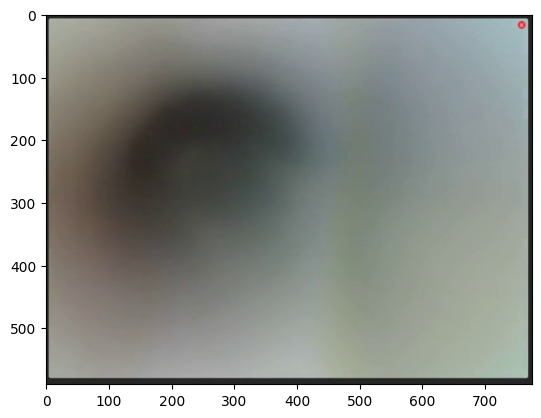

In [223]:
from PIL import Image

# 데이터프레임에서 이미지 파일 경로 및 라벨 추출
train_data_image_paths = (path + train_data["Path"]).tolist()
train_data_labels = train_data["Label"].tolist()

val_data_image_paths = (path + val_data["Path"]).tolist()
val_data_labels = val_data["Label"].tolist()

test_data_image_paths = (path + test_data["Path"]).tolist()
test_data_labels = test_data["Label"].tolist()

print("경로: ", train_data_image_paths[0])
print("라벨: ", train_data_labels[0])

# Use a different variable name for the image
img = Image.open(train_data_image_paths[0])
plt.imshow(img)
plt.show()

### CustomDataset(Dataset)

In [224]:
class CustomDataset(Dataset):
    def __init__(self, data_image_paths, data_labels, transform=None):
        self.data_image_paths = data_image_paths
        self.data_labels = data_labels
        self.transform = transform

    def __len__(self):
        return len(self.data_image_paths)

    def __getitem__(self, idx):
        img_path = self.data_image_paths[idx]
        # print(img_path)
        image = Image.open(img_path).convert('RGB')
        label = self.data_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# **3. 학습 구성**

### 하이퍼 파라미터

In [225]:
# Build config
title = 'pipe_multi'
data = 'data'
device = 'cuda'
batch_size = 32
epochs = 200
lr =1e-4
betas = (0.9, 0.999)
checkpoint_dir = '/content/drive/MyDrive/프로젝트/배관하자판별_이미지분류/checkpoints'

### log 생성

In [226]:
# Set Logger & Checkpoint Directory
os.makedirs(checkpoint_dir, exist_ok=True)
logging.basicConfig(
    filename=f'{title}.log',
    format='%(asctime)s - %(message)s',
    level=logging.INFO,
)

### dataset과 loader 지정

In [227]:
# Transform and Load Data
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.transforms.RandomInvert(p=0.5),
    T.RandomRotation(degrees=90),
    T.RandomPerspective(distortion_scale=0.3, p=0.3),
    T.ToTensor(),
    T.Normalize(mean = (0.461, 0.488, 0.462), std = (0.0143, 0.00876, 0.00973))
])


test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean = (0.461, 0.488, 0.462), std = (0.0143, 0.00876, 0.00973))
])


# Update the datasets with the new transform
train_dataset = CustomDataset(train_data_image_paths, train_data_labels, transform = train_transform)
val_dataset = CustomDataset(val_data_image_paths, val_data_labels, transform = test_transform)
test_dataset = CustomDataset(test_data_image_paths, test_data_labels, transform = test_transform)

In [228]:
# data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, shuffle=False)

### RGB 채널별 통계량 확인

In [229]:
# 이미지의 RGB 채널별 통계량 확인 함수

def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()

    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')

# total_dataset = train_dataset + val_dataset
# print_stats(total_dataset)

# **4.모델 정의**

### SqueezeNet

In [230]:
from torchvision.models import SqueezeNet
import torch.nn as nn
import torch

# SqueezeNet 모델 불러오기
model = SqueezeNet()

# 마지막 레이어 수정
in_features = model.classifier[1].in_channels
model.classifier[1] = nn.Conv2d(in_channels=in_features, out_channels=4, kernel_size=1)

model = model.to(device)

# 모델의 구조 출력
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

### 평가 지표

In [231]:
# Performance Metic, Loss Function, Optimizer

# Build metric function
metric_fn = Accuracy(task='multiclass', num_classes=4)
metric_fn = metric_fn.to(device)

# Build loss function
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1) # label_smoothing=0.1

# Build optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=betas, eps=1e-08, weight_decay=0.05, amsgrad=True) # optimizer = Adam & Weight Decay

# Build scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))

#**5. 훈련**

In [232]:
history = {
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    # train one epoch
    train_summary = train_one_epoch(model, train_loader, metric_fn, loss_fn, device, optimizer, scheduler)

    # evaluate one epoch
    val_summary = eval_one_epoch(model, val_loader, metric_fn, loss_fn, device)

    # log info
    log = (f'epoch {epoch+1}, '
            + f'train_loss: {train_summary["loss"]:.4f}, '
            + f'train_accuracy: {train_summary["accuracy"]:.4f} '
            + f'val_loss: {val_summary["loss"]:.4f}, '
            + f'val_accuracy: {val_summary["accuracy"]:.4f}')
    print(log)
    logging.info(log)

    # save log
    log_path = f'{checkpoint_dir}/{title}_test.log'
    with open(log_path, 'a') as log_file:
      log_file.write(log + '\n')

    # save model
    checkpoint_path = f'{checkpoint_dir}/{title}_test.pt'
    save_model(checkpoint_path, model, optimizer, scheduler, epoch+1)

    # add log in history
    history["loss"].append(train_summary["loss"])
    history["accuracy"].append(train_summary["accuracy"])
    history["val_loss"].append(val_summary["loss"])
    history["val_accuracy"].append(val_summary["accuracy"])

    # check if val_accuracy is 1, then break the loop
    if val_summary["accuracy"] == 1.0:
        print("Validation accuracy reached 1.0. Training will be stopped.")
        break

100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


epoch 1, train_loss: 3.9505, train_accuracy: 0.2303 val_loss: 1.3863, val_accuracy: 0.2406


100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


epoch 2, train_loss: 1.3914, train_accuracy: 0.2523 val_loss: 1.3863, val_accuracy: 0.2406


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 3, train_loss: 1.3886, train_accuracy: 0.2500 val_loss: 1.3863, val_accuracy: 0.2406


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


epoch 4, train_loss: 1.3838, train_accuracy: 0.2801 val_loss: 1.3863, val_accuracy: 0.2406


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 5, train_loss: 1.3837, train_accuracy: 0.2697 val_loss: 1.3863, val_accuracy: 0.2406


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


epoch 6, train_loss: 1.3821, train_accuracy: 0.2535 val_loss: 1.3863, val_accuracy: 0.2406


100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


epoch 7, train_loss: 1.3679, train_accuracy: 0.2755 val_loss: 1.3677, val_accuracy: 0.4385


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


epoch 8, train_loss: 1.3485, train_accuracy: 0.3079 val_loss: 1.3699, val_accuracy: 0.4562


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


epoch 9, train_loss: 1.3595, train_accuracy: 0.3356 val_loss: 1.3863, val_accuracy: 0.2406


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 10, train_loss: 1.3489, train_accuracy: 0.3519 val_loss: 1.3293, val_accuracy: 0.3635


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


epoch 11, train_loss: 1.3148, train_accuracy: 0.3796 val_loss: 1.2525, val_accuracy: 0.2740


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


epoch 12, train_loss: 1.2516, train_accuracy: 0.4340 val_loss: 1.2498, val_accuracy: 0.4052


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


epoch 13, train_loss: 1.1796, train_accuracy: 0.4861 val_loss: 1.2185, val_accuracy: 0.3635


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


epoch 14, train_loss: 1.1622, train_accuracy: 0.4907 val_loss: 1.4394, val_accuracy: 0.2635


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


epoch 15, train_loss: 1.1347, train_accuracy: 0.5023 val_loss: 1.2050, val_accuracy: 0.4385


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 16, train_loss: 1.0378, train_accuracy: 0.5509 val_loss: 1.0320, val_accuracy: 0.4969


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 17, train_loss: 1.0617, train_accuracy: 0.5417 val_loss: 0.9383, val_accuracy: 0.6896


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


epoch 18, train_loss: 0.9666, train_accuracy: 0.6030 val_loss: 1.0158, val_accuracy: 0.5062


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 19, train_loss: 0.9569, train_accuracy: 0.5995 val_loss: 0.9602, val_accuracy: 0.6937


100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


epoch 20, train_loss: 0.8917, train_accuracy: 0.6609 val_loss: 0.8906, val_accuracy: 0.6344


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


epoch 21, train_loss: 0.9009, train_accuracy: 0.6400 val_loss: 1.0073, val_accuracy: 0.4885


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


epoch 22, train_loss: 0.8957, train_accuracy: 0.6493 val_loss: 0.8472, val_accuracy: 0.7250


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


epoch 23, train_loss: 0.8810, train_accuracy: 0.6887 val_loss: 0.8487, val_accuracy: 0.6448


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 24, train_loss: 0.8659, train_accuracy: 0.6898 val_loss: 0.7846, val_accuracy: 0.6740


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


epoch 25, train_loss: 0.8004, train_accuracy: 0.7222 val_loss: 0.7510, val_accuracy: 0.7802


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


epoch 26, train_loss: 0.8326, train_accuracy: 0.7002 val_loss: 0.7571, val_accuracy: 0.7542


100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


epoch 27, train_loss: 0.8678, train_accuracy: 0.6725 val_loss: 0.7324, val_accuracy: 0.7802


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


epoch 28, train_loss: 0.7959, train_accuracy: 0.7303 val_loss: 0.7072, val_accuracy: 0.7844


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 29, train_loss: 0.7866, train_accuracy: 0.7373 val_loss: 0.7287, val_accuracy: 0.7271


100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


epoch 30, train_loss: 0.7868, train_accuracy: 0.7373 val_loss: 0.7171, val_accuracy: 0.7604


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


epoch 31, train_loss: 0.8419, train_accuracy: 0.7130 val_loss: 0.8002, val_accuracy: 0.7594


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


epoch 32, train_loss: 0.7887, train_accuracy: 0.7396 val_loss: 0.7538, val_accuracy: 0.8094


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


epoch 33, train_loss: 0.7596, train_accuracy: 0.7535 val_loss: 0.7262, val_accuracy: 0.7594


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


epoch 34, train_loss: 0.7300, train_accuracy: 0.7604 val_loss: 0.6729, val_accuracy: 0.8146


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


epoch 35, train_loss: 0.7378, train_accuracy: 0.7662 val_loss: 0.6884, val_accuracy: 0.7937


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


epoch 36, train_loss: 0.7814, train_accuracy: 0.7269 val_loss: 0.6887, val_accuracy: 0.8042


100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


epoch 37, train_loss: 0.7139, train_accuracy: 0.7824 val_loss: 0.6632, val_accuracy: 0.8042


100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


epoch 38, train_loss: 0.7334, train_accuracy: 0.7731 val_loss: 0.6808, val_accuracy: 0.8458


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


epoch 39, train_loss: 0.7001, train_accuracy: 0.8021 val_loss: 0.6743, val_accuracy: 0.8063


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 40, train_loss: 0.7459, train_accuracy: 0.7558 val_loss: 0.6515, val_accuracy: 0.8969


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 41, train_loss: 0.7148, train_accuracy: 0.7812 val_loss: 0.6538, val_accuracy: 0.7958


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


epoch 42, train_loss: 0.7003, train_accuracy: 0.7986 val_loss: 0.6535, val_accuracy: 0.7854


100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


epoch 43, train_loss: 0.7077, train_accuracy: 0.7905 val_loss: 0.6487, val_accuracy: 0.7854


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 44, train_loss: 0.6992, train_accuracy: 0.8090 val_loss: 0.6396, val_accuracy: 0.8385


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 45, train_loss: 0.6990, train_accuracy: 0.8032 val_loss: 0.6453, val_accuracy: 0.8896


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


epoch 46, train_loss: 0.7078, train_accuracy: 0.7975 val_loss: 0.6719, val_accuracy: 0.7562


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 47, train_loss: 0.7039, train_accuracy: 0.7847 val_loss: 0.6532, val_accuracy: 0.8573


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


epoch 48, train_loss: 0.6887, train_accuracy: 0.8021 val_loss: 0.6483, val_accuracy: 0.8042


100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


epoch 49, train_loss: 0.6551, train_accuracy: 0.8380 val_loss: 0.6436, val_accuracy: 0.8010


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 50, train_loss: 0.6926, train_accuracy: 0.8056 val_loss: 0.6227, val_accuracy: 0.9260


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 51, train_loss: 0.6798, train_accuracy: 0.8113 val_loss: 0.6390, val_accuracy: 0.8010


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 52, train_loss: 0.6734, train_accuracy: 0.8044 val_loss: 0.6504, val_accuracy: 0.7958


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 53, train_loss: 0.6724, train_accuracy: 0.8206 val_loss: 0.6458, val_accuracy: 0.7906


100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


epoch 54, train_loss: 0.6676, train_accuracy: 0.8218 val_loss: 0.6501, val_accuracy: 0.7854


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


epoch 55, train_loss: 0.6838, train_accuracy: 0.7986 val_loss: 0.6271, val_accuracy: 0.8812


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 56, train_loss: 0.6594, train_accuracy: 0.8194 val_loss: 0.6153, val_accuracy: 0.9031


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


epoch 57, train_loss: 0.7225, train_accuracy: 0.8009 val_loss: 0.6928, val_accuracy: 0.8469


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 58, train_loss: 0.7147, train_accuracy: 0.8067 val_loss: 0.6685, val_accuracy: 0.8510


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 59, train_loss: 0.7060, train_accuracy: 0.8021 val_loss: 0.6561, val_accuracy: 0.9000


100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


epoch 60, train_loss: 0.8027, train_accuracy: 0.7523 val_loss: 0.6583, val_accuracy: 0.7854


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


epoch 61, train_loss: 0.6750, train_accuracy: 0.8229 val_loss: 0.6283, val_accuracy: 0.8229


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 62, train_loss: 0.6582, train_accuracy: 0.8438 val_loss: 0.6144, val_accuracy: 0.8250


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 63, train_loss: 0.6642, train_accuracy: 0.8206 val_loss: 0.6357, val_accuracy: 0.8594


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 64, train_loss: 0.6743, train_accuracy: 0.8148 val_loss: 0.6096, val_accuracy: 0.8990


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 65, train_loss: 0.6463, train_accuracy: 0.8275 val_loss: 0.6311, val_accuracy: 0.8250


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


epoch 66, train_loss: 0.6373, train_accuracy: 0.8530 val_loss: 0.5961, val_accuracy: 0.8354


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


epoch 67, train_loss: 0.6249, train_accuracy: 0.8461 val_loss: 0.5800, val_accuracy: 0.8729


100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


epoch 68, train_loss: 0.6326, train_accuracy: 0.8576 val_loss: 0.6254, val_accuracy: 0.9500


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 69, train_loss: 0.6097, train_accuracy: 0.8738 val_loss: 0.6087, val_accuracy: 0.9187


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 70, train_loss: 0.6322, train_accuracy: 0.8738 val_loss: 0.6039, val_accuracy: 0.8490


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 71, train_loss: 0.6208, train_accuracy: 0.8646 val_loss: 0.5754, val_accuracy: 0.8490


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


epoch 72, train_loss: 0.6134, train_accuracy: 0.8762 val_loss: 0.5743, val_accuracy: 0.9479


100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


epoch 73, train_loss: 0.6172, train_accuracy: 0.8681 val_loss: 0.5888, val_accuracy: 0.8677


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


epoch 74, train_loss: 0.6200, train_accuracy: 0.8715 val_loss: 0.6260, val_accuracy: 0.8219


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


epoch 75, train_loss: 0.6425, train_accuracy: 0.8519 val_loss: 0.5537, val_accuracy: 0.9469


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 76, train_loss: 0.5830, train_accuracy: 0.8958 val_loss: 0.6088, val_accuracy: 0.8354


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


epoch 77, train_loss: 0.5987, train_accuracy: 0.8819 val_loss: 0.5597, val_accuracy: 0.8781


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 78, train_loss: 0.5960, train_accuracy: 0.8912 val_loss: 0.5766, val_accuracy: 0.8542


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


epoch 79, train_loss: 0.5854, train_accuracy: 0.9062 val_loss: 0.6088, val_accuracy: 0.8042


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


epoch 80, train_loss: 0.5970, train_accuracy: 0.8785 val_loss: 0.5626, val_accuracy: 0.9688


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


epoch 81, train_loss: 0.5836, train_accuracy: 0.8854 val_loss: 0.5400, val_accuracy: 0.9531


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 82, train_loss: 0.5791, train_accuracy: 0.8750 val_loss: 0.5753, val_accuracy: 0.8542


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 83, train_loss: 0.5687, train_accuracy: 0.9097 val_loss: 0.5326, val_accuracy: 0.8938


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 84, train_loss: 0.5660, train_accuracy: 0.9074 val_loss: 0.5875, val_accuracy: 0.8823


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


epoch 85, train_loss: 0.5718, train_accuracy: 0.9051 val_loss: 0.5153, val_accuracy: 0.9479


100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


epoch 86, train_loss: 0.5395, train_accuracy: 0.9282 val_loss: 0.5204, val_accuracy: 0.9531


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


epoch 87, train_loss: 0.5693, train_accuracy: 0.9028 val_loss: 0.5766, val_accuracy: 0.8729


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 88, train_loss: 0.5657, train_accuracy: 0.9109 val_loss: 0.5254, val_accuracy: 0.9313


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 89, train_loss: 0.5487, train_accuracy: 0.9167 val_loss: 0.6545, val_accuracy: 0.8271


100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


epoch 90, train_loss: 0.5630, train_accuracy: 0.9132 val_loss: 0.5311, val_accuracy: 0.9531


100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


epoch 91, train_loss: 0.5237, train_accuracy: 0.9398 val_loss: 0.5024, val_accuracy: 0.9260


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 92, train_loss: 0.5207, train_accuracy: 0.9236 val_loss: 0.5255, val_accuracy: 0.8802


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 93, train_loss: 0.5293, train_accuracy: 0.9421 val_loss: 0.5741, val_accuracy: 0.8542


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


epoch 94, train_loss: 0.5224, train_accuracy: 0.9398 val_loss: 0.5391, val_accuracy: 0.8781


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


epoch 95, train_loss: 0.5112, train_accuracy: 0.9421 val_loss: 0.5130, val_accuracy: 0.9573


100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


epoch 96, train_loss: 0.5506, train_accuracy: 0.9167 val_loss: 0.5070, val_accuracy: 0.9688


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


epoch 97, train_loss: 0.5125, train_accuracy: 0.9444 val_loss: 0.4924, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


epoch 98, train_loss: 0.5004, train_accuracy: 0.9549 val_loss: 0.5063, val_accuracy: 0.9583


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 99, train_loss: 0.4962, train_accuracy: 0.9549 val_loss: 0.4759, val_accuracy: 0.9448


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


epoch 100, train_loss: 0.4874, train_accuracy: 0.9653 val_loss: 0.5349, val_accuracy: 0.8698


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 101, train_loss: 0.4943, train_accuracy: 0.9514 val_loss: 0.4711, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


epoch 102, train_loss: 0.4837, train_accuracy: 0.9606 val_loss: 0.4599, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


epoch 103, train_loss: 0.4822, train_accuracy: 0.9618 val_loss: 0.4839, val_accuracy: 0.9469


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 104, train_loss: 0.4777, train_accuracy: 0.9595 val_loss: 0.4642, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 105, train_loss: 0.4965, train_accuracy: 0.9491 val_loss: 0.4748, val_accuracy: 0.9417


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


epoch 106, train_loss: 0.4857, train_accuracy: 0.9618 val_loss: 0.5581, val_accuracy: 0.8750


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 107, train_loss: 0.4997, train_accuracy: 0.9525 val_loss: 0.4824, val_accuracy: 0.9583


100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


epoch 108, train_loss: 0.4784, train_accuracy: 0.9653 val_loss: 0.4609, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.45it/s]


epoch 109, train_loss: 0.4784, train_accuracy: 0.9560 val_loss: 0.4598, val_accuracy: 0.9792


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


epoch 110, train_loss: 0.4672, train_accuracy: 0.9699 val_loss: 0.4669, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 111, train_loss: 0.4644, train_accuracy: 0.9688 val_loss: 0.4912, val_accuracy: 0.9635


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


epoch 112, train_loss: 0.4701, train_accuracy: 0.9664 val_loss: 0.4691, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 113, train_loss: 0.4640, train_accuracy: 0.9688 val_loss: 0.4768, val_accuracy: 0.9635


100%|██████████| 6/6 [00:02<00:00,  2.46it/s]


epoch 114, train_loss: 0.4726, train_accuracy: 0.9699 val_loss: 0.4755, val_accuracy: 0.9500


100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


epoch 115, train_loss: 0.4545, train_accuracy: 0.9815 val_loss: 0.4522, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 116, train_loss: 0.4539, train_accuracy: 0.9792 val_loss: 0.4624, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


epoch 117, train_loss: 0.4642, train_accuracy: 0.9688 val_loss: 0.4520, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 118, train_loss: 0.4538, train_accuracy: 0.9826 val_loss: 0.4638, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 119, train_loss: 0.4505, train_accuracy: 0.9792 val_loss: 0.4774, val_accuracy: 0.9396


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


epoch 120, train_loss: 0.4521, train_accuracy: 0.9757 val_loss: 0.4486, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


epoch 121, train_loss: 0.4488, train_accuracy: 0.9815 val_loss: 0.4539, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.87it/s]


epoch 122, train_loss: 0.4537, train_accuracy: 0.9722 val_loss: 0.4547, val_accuracy: 0.9552


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


epoch 123, train_loss: 0.4481, train_accuracy: 0.9780 val_loss: 0.4471, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


epoch 124, train_loss: 0.4536, train_accuracy: 0.9734 val_loss: 0.4552, val_accuracy: 0.9635


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 125, train_loss: 0.4518, train_accuracy: 0.9722 val_loss: 0.4519, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


epoch 126, train_loss: 0.4434, train_accuracy: 0.9734 val_loss: 0.4449, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


epoch 127, train_loss: 0.4512, train_accuracy: 0.9792 val_loss: 0.4448, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


epoch 128, train_loss: 0.4489, train_accuracy: 0.9769 val_loss: 0.4419, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 129, train_loss: 0.4407, train_accuracy: 0.9850 val_loss: 0.4407, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


epoch 130, train_loss: 0.4476, train_accuracy: 0.9757 val_loss: 0.4504, val_accuracy: 0.9635


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


epoch 131, train_loss: 0.4451, train_accuracy: 0.9792 val_loss: 0.4470, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 132, train_loss: 0.4412, train_accuracy: 0.9838 val_loss: 0.4461, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


epoch 133, train_loss: 0.4435, train_accuracy: 0.9792 val_loss: 0.4429, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


epoch 134, train_loss: 0.4360, train_accuracy: 0.9873 val_loss: 0.4512, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 135, train_loss: 0.4368, train_accuracy: 0.9838 val_loss: 0.4549, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


epoch 136, train_loss: 0.4409, train_accuracy: 0.9792 val_loss: 0.4475, val_accuracy: 0.9635


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 137, train_loss: 0.4368, train_accuracy: 0.9826 val_loss: 0.4404, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 138, train_loss: 0.4393, train_accuracy: 0.9792 val_loss: 0.4373, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


epoch 139, train_loss: 0.4352, train_accuracy: 0.9873 val_loss: 0.4386, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


epoch 140, train_loss: 0.4350, train_accuracy: 0.9792 val_loss: 0.4413, val_accuracy: 0.9656


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


epoch 141, train_loss: 0.4251, train_accuracy: 0.9861 val_loss: 0.4382, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


epoch 142, train_loss: 0.4309, train_accuracy: 0.9826 val_loss: 0.4340, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 143, train_loss: 0.4256, train_accuracy: 0.9873 val_loss: 0.4373, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 144, train_loss: 0.4256, train_accuracy: 0.9838 val_loss: 0.4355, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


epoch 145, train_loss: 0.4283, train_accuracy: 0.9838 val_loss: 0.4378, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


epoch 146, train_loss: 0.4436, train_accuracy: 0.9722 val_loss: 0.4519, val_accuracy: 0.9635


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 147, train_loss: 0.4242, train_accuracy: 0.9896 val_loss: 0.4428, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 148, train_loss: 0.4226, train_accuracy: 0.9826 val_loss: 0.4432, val_accuracy: 0.9708


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


epoch 149, train_loss: 0.4322, train_accuracy: 0.9884 val_loss: 0.4378, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 150, train_loss: 0.4305, train_accuracy: 0.9850 val_loss: 0.4368, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 151, train_loss: 0.4285, train_accuracy: 0.9861 val_loss: 0.4425, val_accuracy: 0.9688


100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


epoch 152, train_loss: 0.4253, train_accuracy: 0.9861 val_loss: 0.4317, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


epoch 153, train_loss: 0.4212, train_accuracy: 0.9850 val_loss: 0.4356, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 154, train_loss: 0.4281, train_accuracy: 0.9850 val_loss: 0.4478, val_accuracy: 0.9688


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


epoch 155, train_loss: 0.4293, train_accuracy: 0.9826 val_loss: 0.4374, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 156, train_loss: 0.4306, train_accuracy: 0.9850 val_loss: 0.4344, val_accuracy: 0.9708


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


epoch 157, train_loss: 0.4295, train_accuracy: 0.9873 val_loss: 0.4324, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


epoch 158, train_loss: 0.4269, train_accuracy: 0.9861 val_loss: 0.4430, val_accuracy: 0.9635


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


epoch 159, train_loss: 0.4296, train_accuracy: 0.9850 val_loss: 0.4388, val_accuracy: 0.9635


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


epoch 160, train_loss: 0.4329, train_accuracy: 0.9803 val_loss: 0.4305, val_accuracy: 0.9708


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 161, train_loss: 0.4248, train_accuracy: 0.9826 val_loss: 0.4316, val_accuracy: 0.9792


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


epoch 162, train_loss: 0.4222, train_accuracy: 0.9896 val_loss: 0.4371, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


epoch 163, train_loss: 0.4264, train_accuracy: 0.9792 val_loss: 0.4325, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 164, train_loss: 0.4212, train_accuracy: 0.9884 val_loss: 0.4359, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


epoch 165, train_loss: 0.4190, train_accuracy: 0.9884 val_loss: 0.4333, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


epoch 166, train_loss: 0.4184, train_accuracy: 0.9850 val_loss: 0.4337, val_accuracy: 0.9708


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 167, train_loss: 0.4258, train_accuracy: 0.9815 val_loss: 0.4384, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 168, train_loss: 0.4185, train_accuracy: 0.9896 val_loss: 0.4316, val_accuracy: 0.9708


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


epoch 169, train_loss: 0.4226, train_accuracy: 0.9815 val_loss: 0.4348, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 170, train_loss: 0.4212, train_accuracy: 0.9861 val_loss: 0.4326, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


epoch 171, train_loss: 0.4221, train_accuracy: 0.9861 val_loss: 0.4319, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


epoch 172, train_loss: 0.4165, train_accuracy: 0.9942 val_loss: 0.4355, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 173, train_loss: 0.4213, train_accuracy: 0.9896 val_loss: 0.4332, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


epoch 174, train_loss: 0.4197, train_accuracy: 0.9873 val_loss: 0.4327, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 175, train_loss: 0.4228, train_accuracy: 0.9884 val_loss: 0.4332, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


epoch 176, train_loss: 0.4193, train_accuracy: 0.9907 val_loss: 0.4310, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


epoch 177, train_loss: 0.4270, train_accuracy: 0.9803 val_loss: 0.4305, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


epoch 178, train_loss: 0.4182, train_accuracy: 0.9873 val_loss: 0.4321, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


epoch 179, train_loss: 0.4188, train_accuracy: 0.9919 val_loss: 0.4326, val_accuracy: 0.9708


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


epoch 180, train_loss: 0.4189, train_accuracy: 0.9896 val_loss: 0.4316, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


epoch 181, train_loss: 0.4175, train_accuracy: 0.9907 val_loss: 0.4344, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 182, train_loss: 0.4156, train_accuracy: 0.9907 val_loss: 0.4325, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


epoch 183, train_loss: 0.4249, train_accuracy: 0.9850 val_loss: 0.4305, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


epoch 184, train_loss: 0.4195, train_accuracy: 0.9884 val_loss: 0.4332, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


epoch 185, train_loss: 0.4214, train_accuracy: 0.9884 val_loss: 0.4337, val_accuracy: 0.9792


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


epoch 186, train_loss: 0.4217, train_accuracy: 0.9850 val_loss: 0.4322, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 187, train_loss: 0.4177, train_accuracy: 0.9884 val_loss: 0.4314, val_accuracy: 0.9708


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


epoch 188, train_loss: 0.4317, train_accuracy: 0.9792 val_loss: 0.4335, val_accuracy: 0.9792


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


epoch 189, train_loss: 0.4178, train_accuracy: 0.9907 val_loss: 0.4323, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


epoch 190, train_loss: 0.4193, train_accuracy: 0.9873 val_loss: 0.4311, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


epoch 191, train_loss: 0.4209, train_accuracy: 0.9838 val_loss: 0.4314, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


epoch 192, train_loss: 0.4130, train_accuracy: 0.9861 val_loss: 0.4311, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


epoch 193, train_loss: 0.4223, train_accuracy: 0.9896 val_loss: 0.4313, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


epoch 194, train_loss: 0.4114, train_accuracy: 0.9942 val_loss: 0.4309, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


epoch 195, train_loss: 0.4224, train_accuracy: 0.9850 val_loss: 0.4309, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


epoch 196, train_loss: 0.4143, train_accuracy: 0.9907 val_loss: 0.4308, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


epoch 197, train_loss: 0.4167, train_accuracy: 0.9861 val_loss: 0.4310, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


epoch 198, train_loss: 0.4146, train_accuracy: 0.9873 val_loss: 0.4310, val_accuracy: 0.9708


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


epoch 199, train_loss: 0.4230, train_accuracy: 0.9815 val_loss: 0.4310, val_accuracy: 0.9708


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

epoch 200, train_loss: 0.4168, train_accuracy: 0.9873 val_loss: 0.4310, val_accuracy: 0.9708


In [233]:
# val

val_accuracy = [x.item() for x in history["val_accuracy"]]
val_loss = [x.item() for x in history["val_loss"]]
accuracy = [x.item() for x in history["accuracy"]]
loss = [x.item() for x in history["loss"]]
print("val_accuracy:", val_accuracy)
print("val_loss", val_loss)
print("accuracy:", accuracy)
print("loss", loss)

import csv
history_path = f'{checkpoint_dir}/{title}_history.csv'
print(history_path)
with open(history_path, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(["accuracy"]+ accuracy)
    writer.writerow(["loss"]+ loss)
    writer.writerow(["val_accuracy"]+ val_accuracy)
    writer.writerow(["val_loss"]+ val_loss)

val_accuracy: [0.24062500894069672, 0.24062500894069672, 0.24062500894069672, 0.24062500894069672, 0.24062500894069672, 0.24062500894069672, 0.4385416507720947, 0.45624998211860657, 0.24062500894069672, 0.36354169249534607, 0.27395832538604736, 0.4052083492279053, 0.36354169249534607, 0.26354166865348816, 0.4385416507720947, 0.49687501788139343, 0.6895833015441895, 0.5062499642372131, 0.6937499642372131, 0.6343750357627869, 0.48854169249534607, 0.7249999642372131, 0.6447916626930237, 0.6739583015441895, 0.7802083492279053, 0.7541666626930237, 0.7802083492279053, 0.784375011920929, 0.7270833849906921, 0.7604166865348816, 0.7593750357627869, 0.809374988079071, 0.7593750357627869, 0.8145833015441895, 0.793749988079071, 0.8041666150093079, 0.8041666150093079, 0.8458333015441895, 0.8062500357627869, 0.8968749642372131, 0.7958333492279053, 0.7854166626930237, 0.7854166626930237, 0.8385416865348816, 0.8895833492279053, 0.7562499642372131, 0.8572916984558105, 0.8041666150093079, 0.801041662693

# **6. 평가**

1. Confusion matrix (test dataset)
2. Learning curve (각각 training dataset, validation dataset)

In [234]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

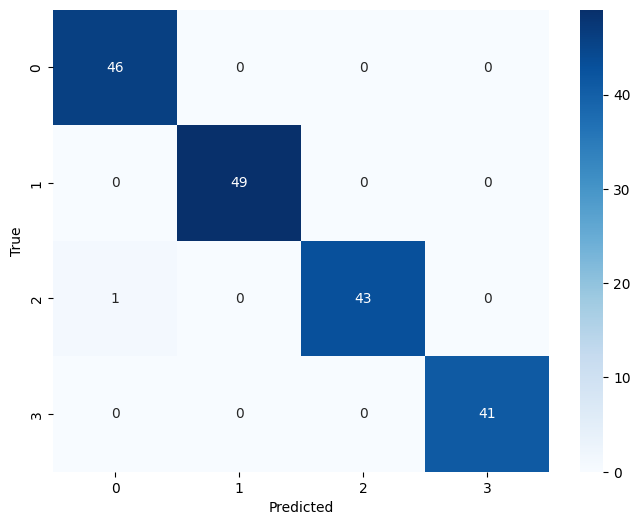

In [235]:
# 1. Confusion Matrix (혼동 행렬)

# 모델로부터 검증 데이터 예측 얻기
model.eval()
all_predictions = []
all_targets = []

for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    all_predictions.extend(predicted.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

# 혼동 행렬 생성
conf_matrix = confusion_matrix(all_targets, all_predictions)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

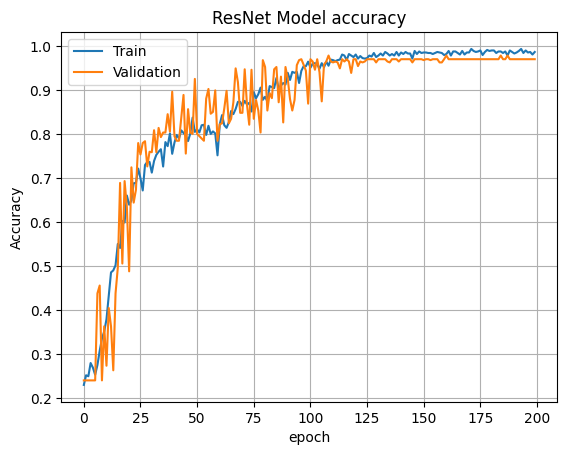

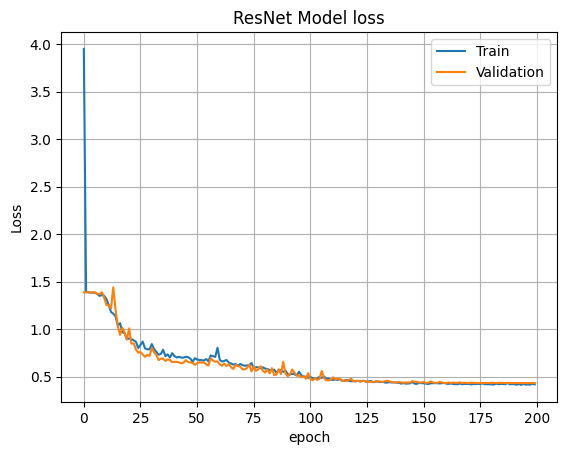

In [236]:
# 2. Learning curve


# accuracy cure
plt.plot([x.item() for x in history["accuracy"]]) # train accuracy
plt.plot([x.item() for x in history["val_accuracy"]]) # validation accuracy
plt.title('ResNet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()


# loss cure
plt.plot([x.item() for x in history["loss"]]) # train loss
plt.plot([x.item() for x in history["val_loss"]]) # validation loss
plt.title('ResNet Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()

In [247]:
# val_dataset에서 각각 라벨이 0,1,2,3 인 데이터를 4개씩 랜덤 추출

import torch
from torch.utils.data import DataLoader, Sampler

class LabelSampler(Sampler): # 라벨별로 지정된 수만큼 데이터를 추출
    def __init__(self, dataset, num_samples_per_label):
        self.dataset = dataset
        self.num_samples_per_label = num_samples_per_label
        self.label_indices = self._create_label_indices()

    # 각 라벨에 해당하는 인덱스를 모아 딕셔너리로 저장
    def _create_label_indices(self):
        label_indices = {label: [] for label in set(self.dataset.data_labels)}
        for i, label in enumerate(self.dataset.data_labels):
            label_indices[label].append(i)
        return label_indices

    # 각 라벨에 대해 지정된 수만큼 무작위로 인덱스를 선택하여 반환
    def __iter__(self):
        indices = []
        for label, indices_per_label in self.label_indices.items():
            if len(indices_per_label) >= self.num_samples_per_label:
                selected_indices = torch.randperm(len(indices_per_label))[:self.num_samples_per_label]
                indices.extend([indices_per_label[idx] for idx in selected_indices])
            else:
                indices.extend(indices_per_label * self.num_samples_per_label)
        return iter(indices)

    # 데이터셋의 전체 길이를 반환
    def __len__(self):
        return len(self.dataset)

# 사용법
num_samples_per_label = 4
label_sampler = LabelSampler(val_dataset, num_samples_per_label)
test_loader = DataLoader(val_dataset, batch_size=16, sampler=label_sampler)

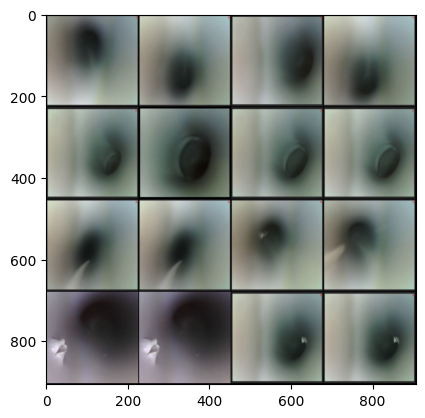

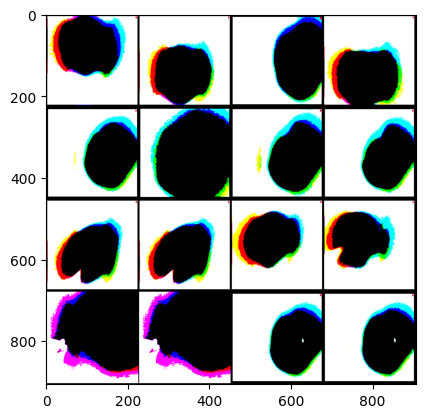

{'정상': 0, '구부러짐': 1, '이물질': 2, '펀칭': 3}

 True
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]

 Predicted
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]

 Correction
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [248]:
from torchvision.utils import make_grid

# 모델로부터 검증 데이터 예측 얻기
model.eval()
all_predictions = []
all_targets = []

mean = np.array([0.4611317, 0.48757568, 0.46162465])
std = np.array([0.014292854, 0.008755223, 0.009734866])

for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    all_predictions.extend(predicted.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

    sample_imgs = inputs.cpu()
    sample_imgs = sample_imgs*std.reshape(1, -1, 1, 1) + mean.reshape(1, -1, 1, 1)
    sample_imgs = np.clip(sample_imgs, 0, 255)

    # 원본 이미지
    grid = make_grid(sample_imgs, nrow=4)
    plt.imshow(grid.numpy().transpose(1, 2, 0))

    # 전처리 이미지(=모델 input 이미지)
    plt.figure()
    grid = make_grid(inputs.cpu(), nrow=4)
    plt.imshow(grid.numpy().transpose(1, 2, 0))

    plt.show()

    sample_predicted = predicted.cpu().numpy()
    sample_targets = targets.cpu().numpy()

    print(mapping)
    print("\n True")
    print(sample_targets)
    print("\n Predicted")
    print(sample_predicted)
    print("\n Correction")
    print(sample_targets==sample_predicted)

    break

# **7. Grad-CAM**

## Grad-CAM 모듈
https://github.com/1Konny/gradcam_plus_plus-pytorch/blob/master/example.ipynb

In [249]:
import cv2
import numpy as np
import torch

def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]

    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result


def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]

        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


def find_densenet_layer(arch, target_layer_name):
    """Find densenet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_transition1'
            target_layer_name = 'features_transition1_norm'
            target_layer_name = 'features_denseblock2_denselayer12'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'classifier'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) >= 3:
        target_layer = target_layer._modules[hierarchy[2]]

    if len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[3]]

    return target_layer


def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_squeezenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features_12'
            target_layer_name = 'features_12_expand3x3'
            target_layer_name = 'features_12_expand3x3_activation'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2]+'_'+hierarchy[3]]

    return target_layer


def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)


def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)

    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)

    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [250]:
import torch
import torch.nn.functional as F

class GradCAM(object):
    """Calculate GradCAM salinecy map.

    A simple example:

        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcam = GradCAM(model_dict)

        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)

        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)

        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)


    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']

        self.gradients = dict()
        self.activations = dict()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        if 'vgg' in model_type.lower():
            target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            target_layer = find_alexnet_layer(self.model_arch, layer_name)
        elif 'squeezenet' in model_type.lower():
            target_layer = find_squeezenet_layer(self.model_arch, layer_name)

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        if verbose:
            try:
                input_size = model_dict['input_size']
            except KeyError:
                print("please specify size of input image in model_dict. e.g. {'input_size':(224, 224)}")
                pass
            else:
                device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
                self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
                print('saliency_map size :', self.activations['value'].shape[2:])


    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


class GradCAMpp(GradCAM):
    """Calculate GradCAM++ salinecy map.

    A simple example:

        # initialize a model, model_dict and gradcampp
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcampp = GradCAMpp(model_dict)

        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)

        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcampp(normed_img, class_idx=10)

        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)


    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        super(GradCAMpp, self).__init__(model_dict, verbose)

    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value'] # dS/dA
        activations = self.activations['value'] # A
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
                activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit

## 준비

In [251]:
cam_dict = dict()
squeezenet_model_dict = dict(type='squeezenet', arch=model, layer_name='features_12_expand3x3_activation', input_size=(224, 224))
squeezenet_gradcam = GradCAM(squeezenet_model_dict, True)
squeezenet_gradcampp = GradCAMpp(squeezenet_model_dict, True)
cam_dict['squeezenet'] = [squeezenet_gradcam, squeezenet_gradcampp]

saliency_map size : torch.Size([13, 13])
saliency_map size : torch.Size([13, 13])


## 실행

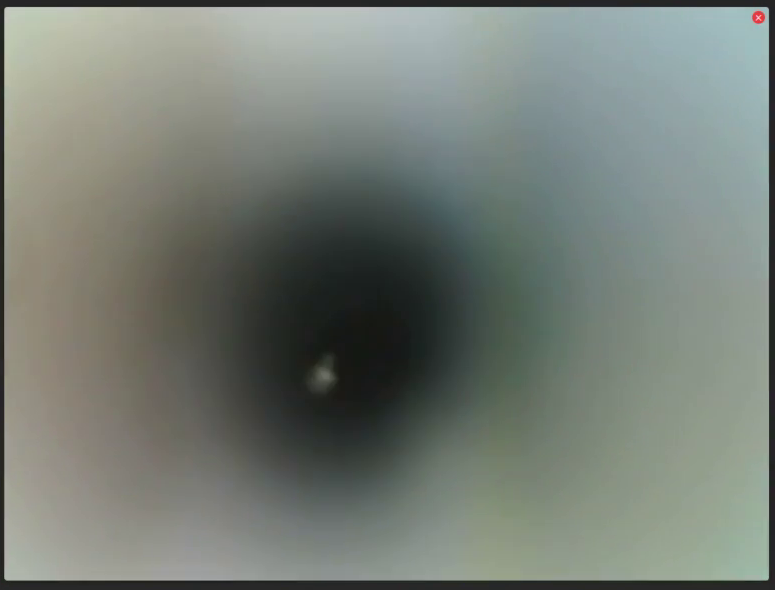

In [252]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

img_path = "./dataset/구부러짐/frame146 (2).png"
img_path = "./dataset/이물질/frame1017.png"
pil_img = PIL.Image.open(img_path)
pil_img

In [253]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

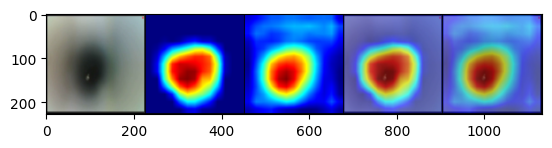

In [254]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask.cpu(), torch_img.cpu())

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), torch_img.cpu())

    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))

images = make_grid(torch.cat(images, 0), nrow=5)
plt.imshow(images.numpy().transpose(1, 2, 0))


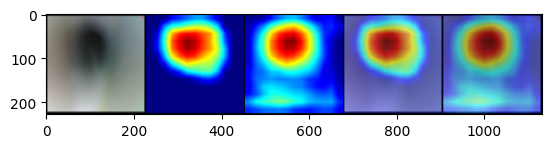

In [255]:
# torch_img = inputs.float()[0].unsqueeze(0)
# normed_torch_img = sample_imgs.to("cuda").float()[0].unsqueeze(0).div(255)

torch_img = sample_imgs.to("cuda").float()[0].unsqueeze(0)
normed_torch_img = normalizer(torch_img)

images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask.cpu(), torch_img.cpu())

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), torch_img.cpu())

    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))

images = make_grid(torch.cat(images, 0), nrow=5)
plt.imshow(images.numpy().transpose(1, 2, 0))


In [256]:
7output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

SyntaxError: invalid decimal literal (<ipython-input-256-183616d6bc80>, line 1)